# 🐍.4 Regression in Python Part 2

*With: Nate & Tyler*


What have we accomplished so far?
> We've developed a linear regression model to infer the relationship between SAT scores and university GPA, which also allows us to generate a prediction for university GPA based on a give SAT score. We know this isn't perfect so we developed a measure, `loss_function`, to understand goodness-of-fit 

*So what's next?* <br>
>Let's improve the fit of our model, which will help us draw better conclusions regarding _causality_ and make more accurate predictions

In [2]:
# Let's import some of the modules we'll need
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
sys.path.append('../../custom')

from db_utils import get_connection, validate_connection, get_data
pd.options.display.float_format = '{:,.2f}'.format

# Import the statsmodels module and associated information we'll need to perform this analysis
import statsmodels.api as sm

# Load data from CSV that we'll be using
data = pd.read_csv('sat_data.csv')
data['Total_SAT'] = data['math_SAT'] + data['verb_SAT']

# Motivation

If we remember in part 1, we were aiming to decide on admissions results to FlexportUniversity and determing a way to predict the highest achieving students from information we had at the time. 

We were also curious about the *causal* relationship different factors might have with university GPA. Imagine that we are considering dropping the SAT as a requirement for applying. Do we think we can get meaningful signal about students without this data point?

We were able to predict college GPA (and thus select our top students) via SAT scores. But, that's not the only information we have about these high school students. We'll aim to increase the indepentent variables we use in our prediction to improve the accuracy of our predictions and get a better understanding of what actually determines GPA.

Recall we defined our equation for linear regresion as
<br><br>
\begin{equation}
Y_i = f(X) = \beta_0 + \beta_1 X_i + \epsilon_i
\end{equation}
<br><br>

We can add additional $\beta_{i}$ values as additional independent variables in our equation and continue to minimize our error.

> What other variables might be useful in predicting college GPA?

> We already estimated the effect of SAT scores on college GPA. Why would adding additional variables give us additional insight into this effect?

In [3]:
# Let's look at our data and think about what fields might allow us to get a better prediction
data.head()

,high_GPA,math_SAT,verb_SAT,comp_GPA,univ_GPA,highschool,Total_SAT
0,2.36,559,536,2.03,2.24,School B,1095
1,2.48,574,602,2.07,2.24,School C,1176
2,2.24,554,542,2.07,2.34,School B,1096
3,2.52,554,507,2.09,2.27,School B,1061
4,2.19,562,507,2.10,2.21,School C,1069


## Let's Brainstorm some ideas of how this might work anecdotally

Our prediction in our last model was based off only a single predictor variable -- let's graph the expected vs predicted values to get an idea of how accurate our model was.

## Let's Review the accuracy of our Univariate Model

In [4]:
# Going to define a function for plotting our test results
def display_model_fit(model: sm.OLS, title) -> None:


    fig = plt.figure()
    plt.scatter(model.model.endog, model.fittedvalues)
    fig.suptitle('%s : R2 = %.2f' %(title, model.rsquared))
    plt.xlabel('Actual %s' %model.model.endog_names)
    plt.ylabel('Predicted %s' %model.model.endog_names)
    plt.plot(np.arange(2,4.2,.2), np.arange(2,4.2,.2), color='red', label="Perfect Prediction")
    fig.legend()
    plt.show()
    return

In [5]:
# Initialize a Univariate Linear Regression like in our last lesson
X_univariate = data.Total_SAT
X_univariate = sm.add_constant(X_univariate)
Y = data.univ_GPA
univariate_model = sm.OLS(Y, X_univariate).fit()

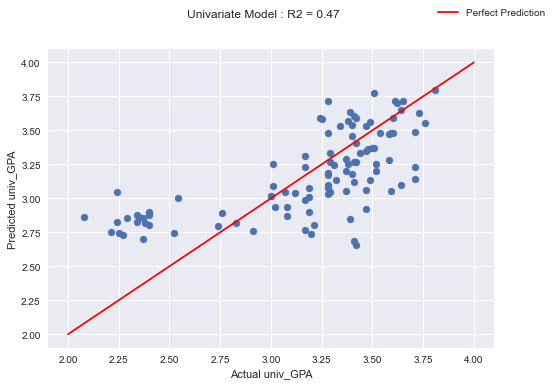

In [6]:
display_model_fit(univariate_model, 'Univariate Model')

Text(0.5, 0, 'Total SAT Score')

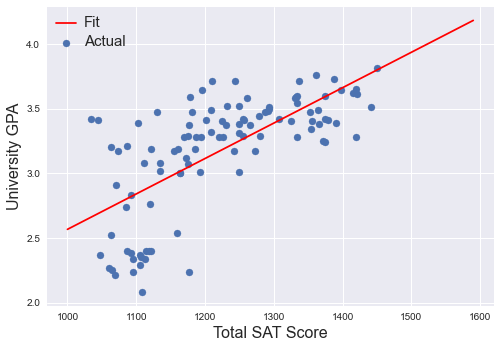

In [7]:
sat_range = np.arange(1000, 1600, 10)
sat_fit = pd.DataFrame(sat_range, index=sat_range, columns=['Total_SAT'])
sat_fit['const'] = 1
sat_fit_line = univariate_model.predict(sat_fit[['const', 'Total_SAT']])
sat_fit_line.plot(color='red')
plt.scatter(data.Total_SAT, data.univ_GPA)

leg = plt.legend(['Fit', 'Actual'])
for i in leg.get_texts():
    i.set_size(15)
    
plt.ylabel('University GPA', size=16)
plt.xlabel('Total SAT Score', size=16)

## Let's build a multivariate model

- Build our X dataset so that it contains multiple independent variables
- Make sure to add a constant and fit the model as above

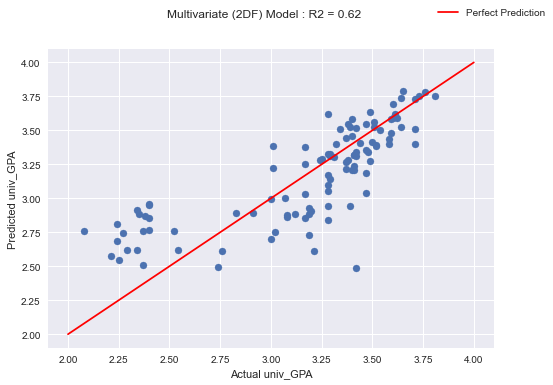

In [8]:
X_mv = data[['high_GPA', 'Total_SAT']]
X_mv = sm.add_constant(X_mv)
mv_model = sm.OLS(Y, X_mv).fit()
display_model_fit(mv_model, 'Multivariate (2DF) Model')

### What do our coefficients look like?

In [9]:
mv_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               univ_GPA   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     84.35
Date:                Wed, 04 Nov 2020   Prob (F-statistic):           2.41e-22
Time:                        08:23:24   Log-Likelihood:                -12.744
No. Observations:                 105   AIC:                             31.49
Df Residuals:                     102   BIC:                             39.45
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5398      0.318      1.699      0.092      -0.091       1.170
high_GPA       0.5415      0.084      6.465      0.000       0.375       0.708
Total_SAT      0.0008      0.000      2.047      0.043    2.46e-05       0.002
==============================================================================
Omnibus:                        2.581   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.275   Jarque-Bera (JB):                2.267
Skew:                          -0.115   Prob(JB):                        0.322
Kurtosis:                       3.682   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
print('SAT coefficient, univariate:   {:,.5f}'.format(univariate_model.params.Total_SAT))
print('SAT coefficient, multivariate: {:,.5f}'.format(mv_model.params.Total_SAT))

SAT coefficient, univariate:   0.00274
SAT coefficient, multivariate: 0.00079


### What happened!?

- Our coefficient for SAT score got *smaller* - why does this make sense?
- What does this tell us about the relationship between high school GPA and SAT score?

It's unsurprising that our two explanatory variables, high school GPA and SAT score, are themselves correlated:

Text(0.5, 0, 'High School GPA')

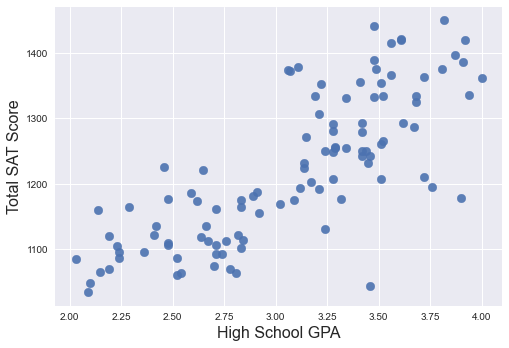

In [16]:
plt.scatter(data.high_GPA, data.Total_SAT, s=75, alpha=0.9)

plt.ylabel('Total SAT Score', size=16)
plt.xlabel('High School GPA', size=16)

What are the implications of this?

To some extent, our univariate model that only included SAT may not have indicated a causal relationship between SAT and university GPA. Because high school GPA is correlated with SAT scores, **we might conclude that the effect of SAT scores on university GPA has nothing to do with the SAT itself - rather, the SAT is just an indicator of better high school grades**.

However, our coefficient on SAT score is still positive and statistically significant, which tells us that the SAT has some explanatory power beyond what you would expect from the correlation of SAT with high school grades. In this sense, we have re-calculated the coefficient for SAT score while "controlling" for the effect of high school grades. 

The idea of "controlling" for a variable can be hand-wavy, especially when you explain it to a stakeholder. But it's not exactly magic. While high school GPA and SAT score are strongly correlated, they're not *perfectly* correlated. If they were perfectly correlated, our model would not be properly identified - there would be many possible combinations of $\beta_{1}$ and $\beta_{2}$ that would give you the same result. 

We can exploit this lack of perfect correlation to understand the individual effects of each variable - there are some students, for example, that had good SAT scores but bad GPAs. How did these students perform? If, on average, this block of students have lower university GPAs, we would infer that GPA has some amount of an independent effect outside of SAT score. 

That's a gross oversimplification, but it introduces the idea of "*ceteris paribus*", or "*all else equal*". Our coffecients are interpreted as the effect of changing one independent variable while holding other variables constant. As long as we include these variables in our model, we can make these kinds of assertions.

That begs the question... what additional factors are we not considering in our model?

## What other information may play a role in high school students?

- Aim to lead discussion towards schools, different standards across schools


## So how can we build a regression against non-numeric variables?

Dummy Variables!

In [18]:
# We'll use a pandas function to create a new df of dummies from our highschool column, then join it
dummies = pd.get_dummies(data.highschool)
dummies.columns = dummies.columns.str.replace(' ', '_')
data = data.join(dummies)

In [19]:
data.head()

,high_GPA,math_SAT,verb_SAT,comp_GPA,univ_GPA,highschool,Total_SAT,School_A,School_B,School_C
0,2.36,559,536,2.03,2.24,School B,1095,0,1,0
1,2.48,574,602,2.07,2.24,School C,1176,0,0,1
2,2.24,554,542,2.07,2.34,School B,1096,0,1,0
3,2.52,554,507,2.09,2.27,School B,1061,0,1,0
4,2.19,562,507,2.10,2.21,School C,1069,0,0,1


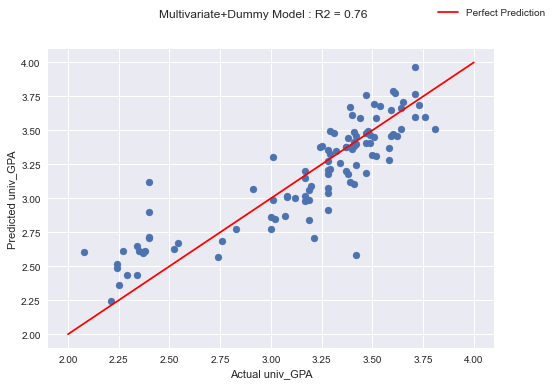

In [21]:
# Now that we have dummy variables we can simply add them to the regression and update our fit
X_dummy = data[['high_GPA', 'Total_SAT', 'School_A', 'School_B', 'School_C']]
X_dummy = sm.add_constant(X_dummy)

dummy_model = sm.OLS(Y, X_dummy).fit()
display_model_fit(dummy_model, 'Multivariate+Dummy Model')

## Great!
### We've improved our Rsquared from 0.47 to 0.76

But we need to discuss how we got here. We've introduced additional variables, which means additional degress of freedom. While in cases this may allow us to describe more of the variance in our data, it may also lead to things like **overfitting** if we're not validating the logic of our model.

First, let's take a closer look at the coefficients:


In [22]:
dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               univ_GPA   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     78.83
Date:                Wed, 04 Nov 2020   Prob (F-statistic):           4.69e-30
Time:                        09:05:01   Log-Likelihood:                 10.768
No. Observations:                 105   AIC:                            -11.54
Df Residuals:                     100   BIC:                             1.733
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3905      0.192      2.029      0.045       0.009       0.772
high_GPA       0.6819      0.070      9.715      0.000       0.543       0.821
Total_SAT      0.0004      0.000      1.243      0.217      -0.000       0.001
School_A       0.3628      0.071      5.110      0.000       0.222       0.504
School_B       0.0864      0.072      1.205      0.231      -0.056       0.229
School_C      -0.0587      0.076     -0.771      0.443      -0.210       0.092
==============================================================================
Omnibus:                        7.527   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               14.466
Skew:                           0.048   Prob(JB):                     0.000723
Kurtosis:                       4.816   Cond. No.                     1.10e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
print('SAT coefficient, univariate:   {:,.5f}'.format(univariate_model.params.Total_SAT))
print('SAT coefficient, multivariate: {:,.5f}'.format(mv_model.params.Total_SAT))
print('SAT coefficient, HS dummies:   {:,.5f}'.format(dummy_model.params.Total_SAT))

SAT coefficient, univariate:   0.00274
SAT coefficient, multivariate: 0.00079
SAT coefficient, HS dummies:   0.00039


In [26]:
data.highschool.value_counts()

School A    54
School B    33
School C    18
Name: highschool, dtype: int64

Our coefficient for School A (or the "School A fixed effect") is large and statistically significant. But we can't say the same for the School B/C fixed effects. One reason? We have a smaller sample of students for these schools.

With dummy variables in particular we have to be mindful of chasing the "long tail" of small data subsets. For example, if there were a "School D" with only a handful of students in the sample, we might estimate a very large fixed effect for that school. But, this is likely to be noise. However, if we add enough variables like this, it could substantially improve our $R^2$ and in-sample fit and make it seem like we are improving the model.

In a predictive context, this is best mitigated via *out-of-sample testing*

In a causal inference context, it helps to pay attention to:
- The standard errors on our coefficients
- The "degrees of freedom" of the model
- Measures of fit like adjusted $R^2$, 

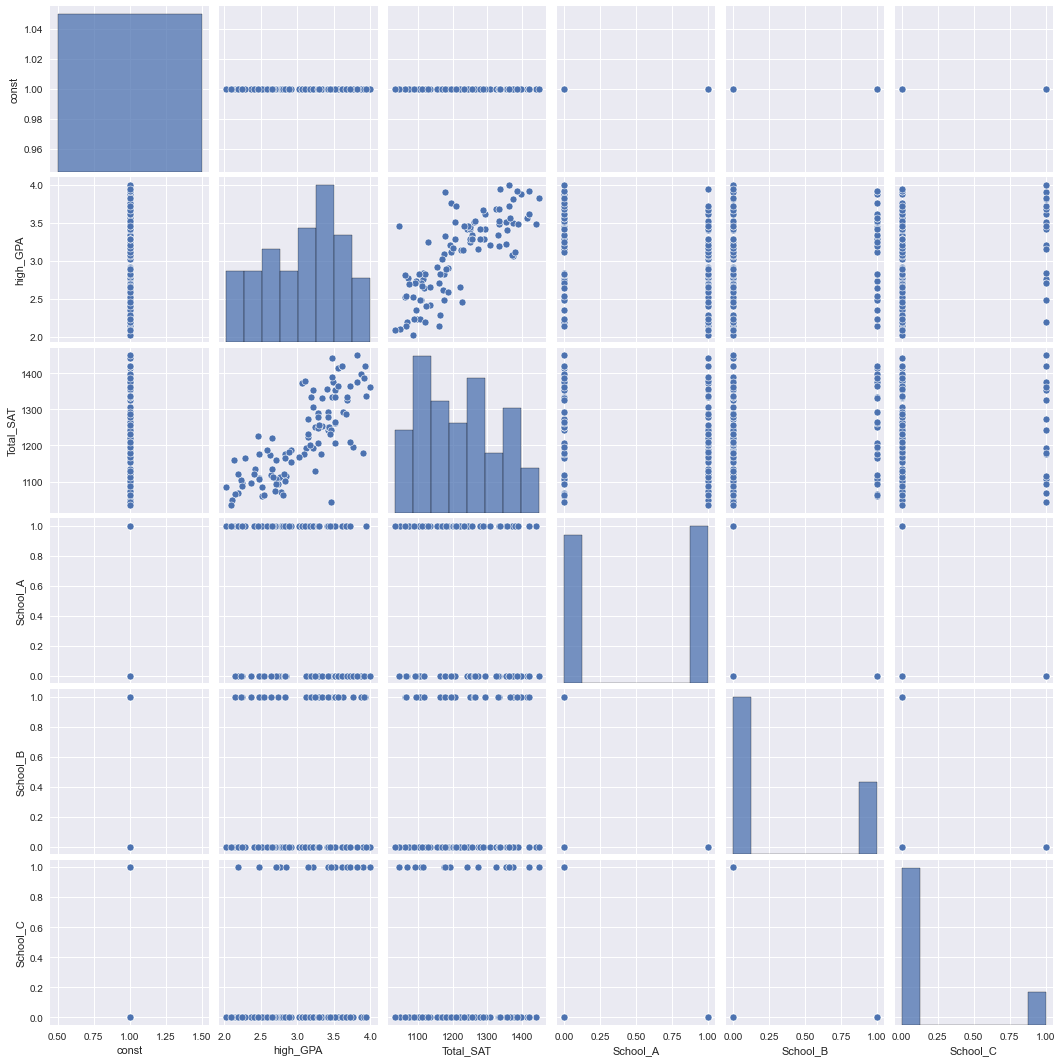

In [34]:
# Let's use a pre-made tool to identify interactions between variables
import seaborn as sns
sns.pairplot(X_dummy)

## Let's think about interactions between schools and scores
<br>
We've discussed that we feel some schools may have higher SAT/GPA scores, but in our model with dummy variables the anecdotal calculation doesn't make much sense. If you review the model you'll see our equation comes out to:
<br>
<br>
\begin{equation}
univGPA = \beta_0 + \beta_1 totalSAT + \beta_2 highGPA + \beta_3 School_A + \beta_4 School_B + \beta_5 School_C
\end{equation}
<br>
In the equation above we're giving specific weights to begin from a certain school, but this doesn't account for what we've described anecdotally. This can be interpreted as students from School A will be starting from a higher baseline GPA in college than students in School C. We described this as certain schools might have different ways of scoring their student's GPAs, aka some are harder than others. We can solve this via interaction variables. We want the equation to look like the following equation:
<br>
<br>
\begin{equation}
univGPA = \beta_0 + \beta_1 totalSAT + \beta_2 highGPA School_A + \beta_3 highGPA School_B + \beta_4 highGPA School_C
\end{equation}

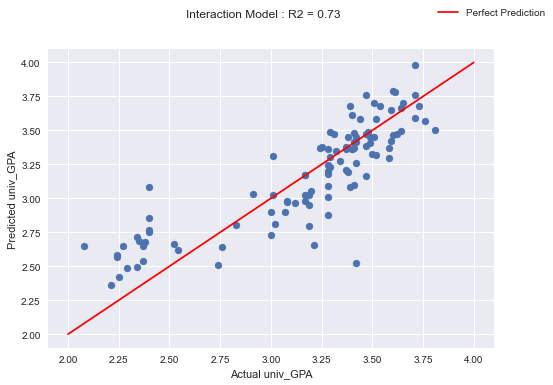

In [38]:
# First we'll initialize our interaction variables & add them to the model
data['high_GPA_x_A'] = data['high_GPA'] * data['School_A']
data['high_GPA_x_B'] = data['high_GPA'] * data['School_B']
data['high_GPA_x_C'] = data['high_GPA'] * data['School_C']
X_interact = data[['Total_SAT', 'high_GPA_x_A', 'high_GPA_x_B', 'high_GPA_x_C']]
X_interact = sm.add_constant(X_interact)

# Next we'll run the model and see what improvement it gives us.
interaction_model = sm.OLS(Y, X_interact).fit()
display_model_fit(interaction_model, 'Interaction Model')

## Space for a Tyler Treatise on Degrees of Freedom, modeling practices etc.